# 【代码+图解】文本表示方法衍进

<h1  style="text-align: center" class="list-group-item list-group-item-action active">介绍</h1><a id = "1" ></a>

在自然语言处理（NLP）中，将原始文本转换为数字形式称为 <b> 文本表示 </b> 请相信我，这一步是NLP管道中最重要的步骤之一，因为如果我们在ML模型中输入不良特征，我们将得到不良结果。在计算机科学中，这通常被称为“垃圾输入，垃圾输出”

<b>我在NLP中观察到，与将顶级算法应用于普通文本表示相比，将良好的文本表示提供给普通算法将使您走得更远</b>

在本笔记本中，我将讨论各种文本表示方案及其优缺点，以便您可以选择最适合您任务的方案之一。我们的主要目标是将给定文本转换为数字形式，以便将其输入到NLP和ML算法中。

![](https://www.oreilly.com/library/view/practical-natural-language/9781492054047/assets/pnlp_0301.png)

在本笔记本中，重点将放在图中的虚线框上。

但在继续进行文本表示步骤之前，首先我们必须得到一个干净的数据集，然后必须对其进行预处理。在本笔记本中，我将只使用几个基本步骤来预处理文本数据。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">导入使用的软件包</h1><a id = "1" ></a>

In [1]:
import os
import random
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

<h1  style="text-align: center" class="list-group-item list-group-item-action active">加载一个干净的数据集</h1><a id = "2" ></a>

Kaggle 数据集是我们要使用的干净数据集的最佳来源之一 [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) 


In [2]:
clean_data = pd.read_csv("../input/twitter-airline-sentiment/Tweets.csv")

In [3]:
clean_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

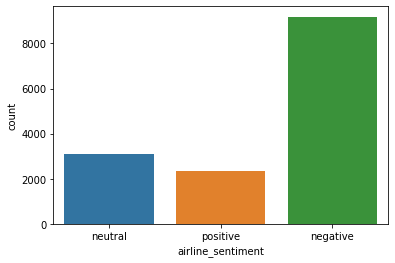

In [5]:
sns.countplot(x="airline_sentiment", data=clean_data)

<h1  style="text-align: center" class="list-group-item list-group-item-action active">基础文本预处理</h1><a id = "3" ></a>

文本预处理步骤包括一些基本任务，以进一步清理可用的文本数据. 这个流程包括:-

**1. Stop-Word 移除** : 在英语中，如a、an、the、as、In、on等词被视为停止词，因此根据我们的要求，我们可以删除它们以减少词汇量，因为这些词没有特定的含义

**2. Lower 转换** : 将所有单词转换为小写，因为大写或小写可能不会对问题产生影响。并且，这样也可以减小词表的大小

**3. Stemming** : 词干处理是指删除后缀并将一个词简化为某种基本形式的过程，这样该词的所有不同变体都可以用相同的形式表示 (e.g., “walk” and “walking” are both reduced to “walk”).

**4. 分词 (Tokenization)** : NLP软件通常通过将文本分解为单词（标记）和句子来分析文本

文本的预处理并不是本笔记本的主要目标，这就是为什么我只简单介绍几个基本步骤。

In [6]:
# First of all let's drop the columns which we don't required

waste_col = [
    "tweet_id",
    "airline_sentiment_confidence",
    "negativereason",
    "negativereason_confidence",
    "airline",
    "airline_sentiment_gold",
    "name",
    "negativereason_gold",
    "retweet_count",
    "tweet_coord",
    "tweet_created",
    "tweet_location",
    "user_timezone",
]

data = clean_data.drop(waste_col, axis=1)

In [7]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [8]:
def sentiment(x):
    if x == "positive":
        return 1
    elif x == "negative":
        return -1
    else:
        return 0

In [9]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words("english")
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"\w+")
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them
tags = r"@\w*"


def preprocess_text(sentence, stem=False):

    sentence = [re.sub(tags, "", sentence)]
    text = []
    for word in sentence:

        if word not in stopwords:

            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
    return tokenizer.tokenize(" ".join(text))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print(f"Orignal Text : {data.text[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(data.text[11])}")

Orignal Text : @VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D

Preprocessed Text : ['i', 'lt', '3', 'pretty', 'graphics', 'so', 'much', 'better', 'than', 'minimal', 'iconography', 'd']


In [11]:
data.text = data.text.map(preprocess_text)
data.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, ve, added, commercials, to, the, e..."
2,neutral,"[i, didn, t, today, must, mean, i, need, to, t..."
3,negative,"[it, s, really, aggressive, to, blast, obnoxio..."
4,negative,"[and, it, s, a, really, big, bad, thing, about..."


现在我们已经对文本数据进行了预处理，所以现在我们可以在本笔记本中进一步讨论，并详细讨论各种文本表示方法。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">One-Hot 编码</h1><a id = "4" ></a>


在 one-hot 编码中, 每一个在词表 (corpus) 中的单词 w 被分配一个独有的 ID (wid)， 它是一个介于 1 到 |V| 之间的数字，这里 V 是词典的大小. 然后，每个字由0和1的V维二进制向量表示。 这是通过|V|维向量来完成的，该向量填充了除索引外的所有0，其中index=wid。在这个索引中，我们简单地将其设为1。 然后将单个单词的表示组合以形成句子表示。

看一个例子

![](https://miro.medium.com/max/886/1*_da_YknoUuryRheNS-SYWQ.png)

In [12]:
# this is an example vocabulary just to make concept clear
sample_vocab = ["the", "cat", "sat", "on", "mat", "dog", "run", "green", "tree"]

In [13]:
# vocabulary of words present in dataset
data_vocab = []
for text in data.text:
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)

In [14]:
# function to return one-hot representation of passed text
def get_onehot_representation(text, vocab=data_vocab):
    onehot_encoded = []
    for word in text:
        temp = [0] * len(vocab)
        temp[vocab.index(word) - 1] = 1
        onehot_encoded.append(temp)
    return onehot_encoded


print('One Hot Representation for sentence "the cat sat on the mat" :')
get_onehot_representation(["the", "cat", "sat", "on", "the", "mat"], sample_vocab)

One Hot Representation for sentence "the cat sat on the mat" :


[[0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0, 0, 0]]

In [15]:
print(f"Length of Vocabulary : {len(data_vocab)}")
print(f"Sample of Vocabulary : {data_vocab[302 : 312]}")

Length of Vocabulary : 14276
Sample of Vocabulary : ['number', 'awaiting', 'return', 'phone', 'call', 'prefer', 'use', 'self', 'service', 'option']


我们在一个给定的数据集中有14276个不同的单词，因此这意味着一个热编码模式的每个单词表示都将是14276维向量，这意味着这个大得多的表示仅用于单个单词。如果我们考虑一个句子的表示，其中包含20个单词，那么它将用`（20, 14276）`大小的矩阵表示。

In [16]:
sample_one_hot_rep = get_onehot_representation(data.text[7], data_vocab)
print(f"Shapes of a single sentence : {np.array(sample_one_hot_rep).shape}")

Shapes of a single sentence : (15, 14276)


In [3]:
# 句子的 one-hot 表示

# data.loc[:, 'one_hot_rep'] = data.loc[:, 'text'].map(get_onehot_representation)

# 如果您运行此单元，它将给您一个内存错误

In [18]:
data.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, ve, added, commercials, to, the, e..."
2,neutral,"[i, didn, t, today, must, mean, i, need, to, t..."
3,negative,"[it, s, really, aggressive, to, blast, obnoxio..."
4,negative,"[and, it, s, a, really, big, bad, thing, about..."


One-hot 编码易于理解，易于实现。然而，它有以下列出的许多缺点：

1. 一个 one-hot 向量的大小与词汇的大小成正比，如果我们考虑真实世界的词汇大小，它可能以百万为单位，因此我们不能用百万维向量表示单个单词。

2. 一个 one-hot 表示不给出文本的固定长度表示，比如，其中包含 32 个单词和 40 个单词的句子具有可变长度表示。但对于大多数学习算法，我们需要相同长度的特征向量。

3. one-hot 表示赋予每个词相同的权重，无论该词对任务是否重要。

4. one-hot 表示并不像嵌入向量那样以适当的数字方式表示单词的含义。考虑一个示例单词 read，reading 应该具有类似的实值向量表示，但在这种情况下，它们具有不同的表示。

5. 假设我们在某篇文章上训练模型，得到10000大小的词汇表，但如果我们在包含习得词汇表中不存在的单词的文本上使用该词汇表会怎么样。这被称为 **超出词表（OOV）** 问题。


<h1  style="text-align: center" class="list-group-item list-group-item-action active">词袋表示</h1><a id = "5" ></a>

词袋（BOW）是一种经典的文本表示技术，广泛应用于自然语言处理，尤其是文本分类问题。它背后的关键思想如下：将所考虑的文本表示为一个单词袋（集合），同时忽略顺序和上下文。

和 one-hot 编码类似，BOW 将单词映射到 1 和 |V| 之间的唯一整数 ID。然后将语料库中的每个文档转换为 |V| 维度的向量。向量的第 i 个分量中，i=wid，简单地说就是单词 w 在文档中出现的次数，也就是说，我们简单地通过它们在文档中的出现计数对 V 中的每个单词进行评分。

我们看一个例子:

假设我们有一个词汇表 **V，由单词-->{the，cat，sat，in，hat，with}** 组成，那么几个句子的单词表示将如下

![](https://miro.medium.com/max/1400/1*3IACMnNpwVlCl8kSTJocPA.png)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

sample_bow = CountVectorizer()

# sample_corpus = [['the', 'cat', 'sat'],
#                  ['the', 'cat', 'sat', 'in', 'the', 'hat'],
#                  ['the', 'cat', 'with', 'the', 'hat']]

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)


def get_bow_representation(text):
    return sample_bow.transform(text)


print(f"Vocabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence 'the cat cat sat in the hat'")
print(get_bow_representation(["the cat cat sat in the hat"]).toarray())

Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the cat cat sat in the hat'
[[2 1 1 1 2 0]]


有时，我们不关心文本中单词的出现频率，我们只想表示文本中是否存在单词。在这种情况下，我们只需使用 binary=True 初始化 CountVector。

In [20]:
sample_bow = CountVectorizer(binary=True)

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)


def get_bow_representation(text):
    return sample_bow.transform(text)


print(f"Vacabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print(
    "\nBag of word Representation of sentence 'the the the the cat cat sat in the hat'"
)
print(get_bow_representation(["the the the the cat cat sat in the hat"]).toarray())

Vacabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the the the the cat cat sat in the hat'
[[1 1 1 1 1 0]]


In [21]:
# generate bag of word representation for given dataset

bow = CountVectorizer()
bow_rep = bow.fit_transform(data.loc[:, "text"].astype("str"))

In [22]:
# intrested one can see vocabulary of given corpus by uncommenting below code line

# bow.vocabulary_

In [23]:
print(f"Shape of Bag of word representaion matrix : {bow_rep.toarray().shape}")

Shape of Bag of word representaion matrix : (14640, 14238)


正如我们所知，one-hot 表示并没有给出文本的固定长度表示，但从上述单元格的输出中，我们可以解释，单词包对于每个单词都有固定长度的向量表示（14238维），但在这种情况下，它也太大了。

**Bag of words(BoW) 编码优势** :

1. 就像 one-hot 编码, BoW 很容易理解和实现.

2. 使用这种表示法，与具有完全不同单词的文档相比，具有相同单词的文档将在欧几里德空间中具有彼此更接近的向量表示。

    woman看看下面的例子 

    S1 = "cat on the mat" --> BoW Representation --> {0 1 1 0 1 0 1} <br>
    S2 = "mat on the cat" --> BoW Representation --> {0 1 1 0 1 0 1} <br>
    S3 = "dog in the mat" --> BoW Representation --> {0 1 0 1 1 1 0} <br>

    S1 和 S2 之间的距离为 0，而 S1 和 S3 之间的距离是 2。因此，由 BoW 方案产生的向量空间捕获了文档的语义相似性。因此，如果两个文档具有相似的词汇表，它们在向量空间中会彼此更接近，反之亦然。

3. 我们对任意长度的任何句子都有固定长度编码。

**Bag of words(BoW) 编码劣势** :

1. 向量的大小随着词汇表的大小而增加，在我们的例子中，它是 14238 维的。因此，稀疏性仍然是一个问题。控制它的一种方法是将词汇量限制为 n 个最频繁的单词

2. 它没有捕捉到意思相同的不同单词之间的相似性。假设我们有三个文档：“walk”、“walked” 和 “walking”。所有三个文档的弓形向量的间距相等

3. 该表示没有任何方法来处理 **超出词表（OOV）** 词（即，在用于构建向量器的语料库中未看到的新词）

4. 顾名思义，它是一个单词的“袋子”，在这个表示中，词序信息丢失了。在该方案中，S1 和 S2 将具有相同的表示。


<h1  style="text-align: center" class="list-group-item list-group-item-action active">N-Grams 词袋</h1><a id = "6" ></a>

到目前为止，我们看到的所有表示方案都将单词视为独立的单位。没有短语或词序的概念。bag-of-n-grams（BoN）方法试图解决这一问题。它通过将文本分成 n 个连续单词（或 tokens）的块来实现。这可以帮助我们捕捉一些以前的方法无法做到的上下文。每个块称为n-gram。

**可以简单地说，单词袋（BoW）是 n=1 的 n-gram 袋的特例。**

因此，语料库词汇 V 只不过是整个文本语料库中所有独特的 n-gram 的集合。然后，语料库中的每个文档由长度为 |V| 的向量表示。该向量仅包含文档中存在的 n-grams 的频率计数，不存在的 n-grams 为零。

看看下面的例子

![](https://i.stack.imgur.com/8ARA1.png)

下面的代码单元显示了一个 BoN 表示的示例，其中考虑了 1-3 个 n-gram 单词特征来表示我们迄今为止使用的语料库。

In [24]:
# Bag of 1-gram (unigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range=(1, 1))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)


def get_boN_representation(text):
    return sample_boN.transform(text)


print(
    f"Unigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}"
)
print(
    "\nBag of 1-gram (unigram) Representation of sentence 'the cat cat sat in the hat'"
)
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Unigram Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of 1-gram (unigram) Representation of sentence 'the cat cat sat in the hat'
[[2 1 1 1 2 0]]


In [25]:
# Bag of 2-gram (bigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range=(2, 2))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)


def get_boN_representation(text):
    return sample_boN.transform(text)


print(
    f"Bigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}"
)
print(
    "\nBag of 2-gram (bigram) Representation of sentence 'the cat cat sat in the hat'"
)
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Bigram Vocabulary mapping for given sample corpus : 
 {'the cat': 4, 'cat sat': 0, 'sat in': 3, 'in the': 2, 'the hat': 5, 'cat with': 1, 'with the': 6}

Bag of 2-gram (bigram) Representation of sentence 'the cat cat sat in the hat'
[[1 0 1 1 1 1 0]]


In [26]:
# Bag of 3-gram (trigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range=(3, 3))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)


def get_boN_representation(text):
    return sample_boN.transform(text)


print(
    f"Trigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}"
)
print(
    "\nBag of 3-gram (trigram) Representation of sentence 'the cat cat sat in the hat'"
)
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Trigram Vocabulary mapping for given sample corpus : 
 {'the cat sat': 4, 'cat sat in': 0, 'sat in the': 3, 'in the hat': 2, 'the cat with': 5, 'cat with the': 1, 'with the hat': 6}

Bag of 3-gram (trigram) Representation of sentence 'the cat cat sat in the hat'
[[1 0 1 1 0 0 0]]


**下面是 BoN 表示的主要的优点和缺点:**

1. 它以 n-gram 的形式捕获一些上下文和词序信息。

2. 因此，生成的向量空间可以捕获一些语义相似性。与具有完全不同的 n-gram 的文档相比，具有相同的 n-gram 的文档在欧几里德空间中将具有彼此更接近的向量。

3. 随着 n 的增加，维数（由于稀疏性）仅快速增加。

4. 它仍然无法解决 **超出词表（OOV）** 的问题。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">TF-IDF</h1><a id = "7" ></a>

在我们迄今为止看到的所有三种方法中，文本中的所有单词都被视为同等重要。没有任何概念认为文档中的某些单词比其他单词更重要。TF-IDF 或术语频率逆文档频率 （term frequency-inverse document frequency）解决了这个问题。它旨在量化给定单词相对于文档和语料库中其他单词的重要性。

TF-IDF 背后的直觉如下：如果一个单词 w 在句子 S1 中出现多次，但在语料库中的其余句子 Sn 中没有太多出现，那么单词 w 对句子 S1 一定非常重要。w 的重要性应与其在 S1 中的频率成比例增加（该单词在句子 S1 出现多少次），但同时，它的重要性应与该词在语料库中其他句子Sn 中的频率成比例地降低**从数学上讲，这是使用两个量来捕获的：TF 和 IDF。然后将两者相乘，得到 TF-IDF 分数**

**TF (term frequency) 测量术语或单词在给定文档中出现的频率。**

TF的数学表达式

![image-1.png](http://aimaksen.bslience.cn/tfidf1.jpg)

**IDF (inverse document frequency)** m衡量整个语料库中术语的重要性。在计算 TF 时，所有项都具有同等的重要性（权重）。然而，众所周知，像 is、are、am 等停止词并不重要，即使它们经常出现。为了解释这些情况，IDF 对语料库中非常常见的术语进行了加权，并对罕见的术语进行加权。项 TF-IDF 计算如下：

!![image-2.png](http://aimaksen.bslience.cn/tfidf2.jpg)

TF-IDF 分数是这两个术语的乘积。因此，TF-IDF 得分 ＝ TF*IDF。让我们考虑一个例子。

Sentence A = The Car is Driven on the Road <br>
Sentence B = The Truck is Driven on the highway <br>

TF-IDF 分数的计算如下所示：

![](https://cdn-media-1.freecodecamp.org/images/1*q3qYevXqQOjJf6Pwdlx8Mw.png)
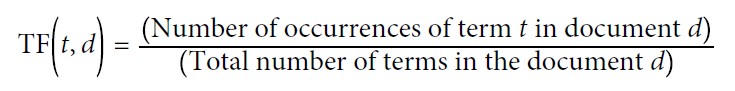

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]
tfidf_rep = tfidf.fit_transform(sample_corpus)
print(f"IDF Values for sample corpus : {tfidf.idf_}")


print("TF-IDF Representation for sentence 'the cat sat in the hat' :")
print(tfidf.transform(["the cat sat in the hat"]).toarray())

IDF Values for sample corpus : [1.         1.28768207 1.69314718 1.28768207 1.         1.69314718]
TF-IDF Representation for sentence 'the cat sat in the hat' :
[[0.29903422 0.385061   0.50630894 0.385061   0.59806843 0.        ]]


与 BoW 类似，我们可以使用 TF-IDF 向量来计算两个文本之间的相似度，使用类似于欧几里得距离或余弦相似度的相似度度量。TF-IDF 是信息等应用场景中常用的表示形式检索和文本分类。然而，尽管 TF-IDF 在捕捉单词之间的相似性方面优于我们之前看到的矢量化方法，**但它仍然受到高维度诅咒的困扰**

**TF-IDF 表示的主要有点和缺点:**

1. 与上面讨论的技术相比，它的实现并不那么容易 
2. 我们对任意长度的任何句子都有固定长度编码
3. 特征向量是高维表示。维度随着词汇的大小而增加
4. 它确实捕捉到了这个句子的一些语义。
5. 他们也无法处理OOV单词

至此，我们结束了基本的矢量化方法。现在，让我们开始研究分布式表示。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Word2vec 词嵌入 (Word Embeddings)</h1><a id = "8" ></a>

**Word Embeddings**：它们是单词的实值向量表示，允许具有相同含义的单词具有相似的表示。因此，我们可以说词嵌入是词在实值向量中的意义的投影。

Word2vec 是 2013 年发布的一种单词嵌入技术。Word2vec 算法使用神经网络模型从大量文本中学习单词关联。

正是词语的表示使具有相同含义的词语具有相似的表示，Word2vec 通过将词语的含义投影到向量空间中来实现这一点，在向量空间中，具有相似含义的词语将倾向于聚集在一起，并且具有非常不同的含义的词语彼此相距很远。

**使用预训练 (Pre-trained) word2vec 词嵌入 (word embeddings)** <br>
训练自己的单词嵌入是一个非常昂贵的过程（从时间和计算两方面来说）。谢天谢地，在许多情况下，没有必要训练自己的嵌入。有人在大型语料库（如维基百科、新闻文章，甚至整个网络）上训练单词嵌入，并将单词及其相应的向量放到了网络上。这些嵌入可以下载并用于获取所需单词的向量。

一些最流行的预训练嵌入是谷歌的 Word2vec、斯坦福的 GloVe 和 Facebook 的 fasttext 嵌入，仅举几个例子。

在下面的代码中，cell 演示了如何使用预训练的 word2vec 单词嵌入。

In [28]:
from gensim.models import KeyedVectors, Word2Vec

pretrained_path = "../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin"

Word2VecModel = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)

正如我们所了解的，Word2vec 对于具有相同含义的单词确实具有类似的向量表示，因此让我们检查类似的单词是否为 “good”

In [29]:
print(Word2VecModel.most_similar("good"))

[('great', 0.7291510105133057), ('bad', 0.7190051078796387), ('terrific', 0.6889115571975708), ('decent', 0.6837348341941833), ('nice', 0.6836092472076416), ('excellent', 0.644292950630188), ('fantastic', 0.6407778263092041), ('better', 0.6120728850364685), ('solid', 0.5806034803390503), ('lousy', 0.576420247554779)]


In [30]:
print(Word2VecModel["good"])

[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891  0.08496094  0.23535156 -0.10107422 -0.03564453
 -0.04736328  0.04736328 -0.14550781 -0.10986328  0.14746094 -0.23242188
 -0.07275391  0.19628906 -0.37890625 -0.07226562  0.04833984  0.11914062
  0.06103516 -0.12109375 -0.27929688  0.05200195  0.04907227 -0.02709961
  0.1328125   0.03369141 -0.32226562  0.04223633 -0.08789062  0.15429688
  0.09472656  0.10351562 -0.02856445  0.00128174 -0.0042

在上述代码单元的输出中，我们可以看到单词 “good” 的300维实值向量。

上面的几个单元是关于使用预训练的 word2vec 表示的。现在在接下来的单元中，我们将重点学习/训练我们自己的 Word2vec 表示。

**训练我们自己的 embeddings**

现在，我们将重点培训我们自己的单词嵌入。为此，我们将研究在最初的 Word2vec 方法中提出的两种架构变体。这两种变体是：

1. Continuous bag of words (CBOW)
2. SkipGram

这两者在许多方面都有很多相似之处。

在本节中，我们将使用 “The quick brown fox jumps over the lazy dog” 作为示例文本。

**1. Continuous bag of words (CBOW)**

在 CBOW 中，主要任务是建立一个语言模型，在给定中心词出现的上下文词的情况下，正确预测中心词。考虑我们的示例句子，我们将“跳跃”一词作为中心词，然后其上下文由其附近的词构成。如果我们将上下文大小设为 2，那么对于我们的示例，上下文由 brown，fox，over，the 给出。CBOW 使用上下文词预测目标词跳跃，如下图所示
<br><br>

![image-1.png](http://aimaksen.bslience.cn/cbow1.jpg)

<br><br>
现在，下一个任务是为这个任务创建一个形式（X，Y）的训练样本，其中X是上下文词，Y是中心词。在这种情况下，我们定义 context window=2。
![image-3.png](http://aimaksen.bslience.cn/cbow2.jpg)

<br><br>
现在我们已经准备好了训练数据，让我们关注模型。为此，我们构造了一个浅层网络（它很浅，因为它只有一个隐藏层）。我们假设我们想学习 D-dim 单词嵌入。此外，设 V 为文本语料库的词汇。

![image-4.png](http://aimaksen.bslience.cn/cbow3.jpg)


<br><br>
目标是学习嵌入矩阵 E|V| x d。首先，我们随机初始化矩阵。这里，|V| 是语料库词汇的大小，d 是嵌入的维度。让我们一层一层地分解图中的浅层网络。在输入层中，上下文中的词的索引用于从嵌入矩阵 E|V| x d 中提取相应的行。然后，将提取的向量相加以获得单个 d-dim 向量，并将其传递到下一层。下一层简单地获取该d向量并将其与另一个矩阵 E'd x|V| 相乘。这给出了 1 x |V| 向量，该向量被送到 softmax 函数以获得词汇空间上的概率分布。将该分布与标签进行比较，并使用反向传播相应地更新矩阵 E 和 E’。在训练结束时，E 是我们想要学习的词嵌入矩阵。
<br><br>

**2. SkipGram** 

SkipGram 与 CBOW 非常相似，但有一些细微的变化。在 Skip-Gram 中，任务是从中心词预测上下文词。对于我们的上下文大小为 2 的玩具语料库，使用中心词“跳跃”，我们尝试预测上下文中的每个词-“brown,” “fox,” “over,” “the”，如下图所示

![image-5.png](http://aimaksen.bslience.cn/skip1.jpg)

现在，我们将为这个任务创建一个形式（X，Y）的训练样本，其中X将是中心词，Y将是上下文词。

<br>
<br>

![image-6.png](http://aimaksen.bslience.cn/skip2.jpg)

<br>
<br>

![image-9.png](http://aimaksen.bslience.cn/skip3.jpg)

<br>
<br>

用于训练 SkipGram 模型的浅层网络，如下图所示，与用于 CBOW 的网络非常相似，但有一些小的变化。在输入层中，目标中的字的索引用于从嵌入矩阵 E|V| x d 中提取相应的行。然后将提取的向量传递到下一层。下一层简单地获取这个d向量，并将其与另一个矩阵 E'd x|V| 相乘。这给出了 1 x |V| 向量，该向量被馈送到 softmax 函数以获得词汇空间上的概率分布。将该分布与标签进行比较，并使用反向传播相应地更新矩阵 E 和 E’。在训练结束时，E 是我们想要学习的嵌入矩阵。

**实现** : 

最常用的实现之一是 gensim。我们必须选择几个超参数（即在开始训练过程之前需要设置的变量）。让我们看两个例子。

词向量的维数

顾名思义，这决定了学习嵌入的空间。虽然没有理想的数字，但通常构建维度在 50-500 之间的词向量，并在我们使用它们的任务中对其进行评估，以选择最佳选项。在 gensim 中，我们通过将 “vector_size” 参数设置为所需的大小来实现这一点。

上下文窗口大小 (Context window)

在gensim中，我们通过将 “window” 参数设置为所需的大小来实现这一点。

我们还可以做出其他选择，例如是否使用 CBOW 或 SkipGram 来学习嵌入。

接下来的几个代码单元显示了CBOW的实现

In [31]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

print("Sentences on Which We are gonna train our CBOW Word2Vec Model:\n")
print(common_texts)

Our_CBOW_Word2Vec_Model = Word2Vec(
    common_texts, vector_size=10, window=5, min_count=1, workers=8, sg=0
)
Our_CBOW_Word2Vec_Model.save("Our_CBOW_Word2Vec_Model.w2v")
print("Model Saved")

Sentences on Which We are gonna train our CBOW Word2Vec Model:

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]
Model Saved


In [32]:
Our_CBOW_Word2Vec_Model.wv.most_similar("human", topn=5)

[('graph', 0.3586883544921875),
 ('system', 0.22743134200572968),
 ('time', 0.1153423935174942),
 ('interface', 0.09816539287567139),
 ('survey', 0.014487894251942635)]

In [33]:
Our_CBOW_Word2Vec_Model.wv["human"]

array([-0.00410223, -0.0836895 , -0.05600014,  0.07104538,  0.0335254 ,
        0.07225668,  0.06800246,  0.07530741, -0.03789156, -0.00561807],
      dtype=float32)

上面的单元格显示了 CBOW 模型的代码实现，可以使用 tunning 超参数进行实验。感兴趣的人可以通过将 sg hyperparameter 设置为 1 进行实验，然后该模型将变为跳跃图模型。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Glove 词嵌入(Word Embeddings)</h1><a id = "9" ></a>

GloVe 代表单词表示的全局向量，是另一种单词嵌入技术，它是斯坦福大学的一个开源项目，于 2014 年推出的。为了刷新，单词向量将单词放入一个很好的向量空间，相似的单词聚集在一起，不同的单词相互排斥。手套的优点是，与 Word2vec 不同，GloVe 不仅依赖于局部统计（单词的局部上下文信息），还结合了全局统计（单词共现）来获得单词向量。但请记住，GloVe 和 Word2vec之间有很大的协同作用。GloVe 可以用来查找同义词、公司产品关系、邮政编码和城市等词之间的关系。

可能会出现这样一个问题：如果我们有 word2vec 作为一种好的单词嵌入技术，为什么我们需要 GloVe，因为 word2vec 只依赖于语言的本地信息。也就是说，为给定单词学习的语义只受周围单词的影响。

举个例子，

The cat sat on the mat

If you use Word2vec, it wouldn’t capture information like,
如果你使用Word2vec，它不会捕获像这样的信息，

“cat” 和 “mat” 这两个词的特殊语境是什么？

或者

“the” 是一个 stopword 吗?

下面的可能是次优的，特别是在理论家的眼中。

GloVe 是建立在一个重要思想之上的，你可以从同现矩阵中推导出单词之间的语义关系。给定具有 V 个单词的语料库，共现矩阵 X 将是V X V矩阵，其中 X 的第 i 行和第 j 列，X_ij 表示单词 i 与单词 j 共现的次数。示例共现矩阵可能如下所示。

![](https://miro.medium.com/max/434/1*QWcK8CIDs8kMkOwsOxvywA.png)

“the cat sat on the mat” 句子的共现矩阵，窗口大小为 1。正如你可能注意到的，它是一个对称矩阵。

有关 Glove 词嵌入的详细信息，请参阅 [This article](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)

In [34]:
Glove_path = "../input/glove6b/glove.6B.100d.txt"
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = "glove.6B.100d.txt.word2vec"
glove2word2vec(Glove_path, word2vec_output_file)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  after removing the cwd from sys.path.


(400000, 100)

In [35]:
from gensim.models import KeyedVectors

# load the Stanford GloVe model
filename = "./glove.6B.100d.txt.word2vec"
Glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [36]:
print("Most similar words to word 'human' : ")
Glove_model.most_similar("human")

Most similar words to word 'human' : 


[('animal', 0.7462460398674011),
 ('rights', 0.7322573661804199),
 ('humans', 0.6607711911201477),
 ('animals', 0.6567643284797668),
 ('body', 0.6552972197532654),
 ('nature', 0.6483666896820068),
 ('beings', 0.6467736959457397),
 ('organization', 0.6319881081581116),
 ('scientific', 0.630841076374054),
 ('common', 0.6211239099502563)]

In [37]:
print("Glove Word Embeddings of word 'human' ")
Glove_model["human"]

Glove Word Embeddings of word 'human' 


array([ 3.3864e-01,  5.9663e-01,  5.3322e-01,  3.1404e-01,  1.5321e-01,
        3.1749e-01, -4.2940e-01, -2.9150e-01, -2.1047e-03, -3.9309e-01,
       -8.5441e-01, -8.0708e-02,  1.2118e+00,  6.9316e-02,  8.0613e-03,
        8.7888e-01,  3.1908e-02,  5.8655e-01, -5.4892e-01, -7.8468e-03,
        1.7327e-01, -2.6693e-01,  4.2802e-01,  6.6123e-02,  5.1847e-01,
        7.7226e-01,  2.0608e-01, -4.5836e-01,  3.5485e-01,  7.1547e-01,
        6.0855e-01,  2.0254e-01, -4.8756e-01,  5.7974e-01,  8.6728e-02,
       -5.1852e-01, -3.7274e-01,  1.0014e+00, -2.9259e-01,  3.2290e-01,
       -9.7563e-01, -2.2288e-01, -2.3335e-01, -2.6891e-01,  1.4612e-01,
        1.2004e-01, -2.0402e-01, -9.4647e-02, -1.5402e+00, -5.9510e-02,
        1.0887e+00, -2.4998e-01, -2.5808e-01,  1.2798e+00, -1.2849e-01,
       -1.4511e+00, -2.4686e-01, -9.5046e-02,  1.7425e+00,  1.1977e-01,
       -1.9206e-01,  4.4368e-01, -1.6453e-01, -7.6663e-01,  1.1100e+00,
        4.6748e-01, -2.4673e-02,  4.7179e-03,  6.9761e-01, -2.29

**Word2Vec 优点:**

1. 这个想法非常直观，它将未标记的原始语料库转换为标记数据（通过将目标词映射到其上下文词），并在分类任务中学习词的表示。

2. 数据可以以在线方式输入模型，并且需要很少的预处理，因此需要很少的内存。

3. 目标词与其上下文词之间的映射隐含地将次线性关系嵌入到词的向量空间中，从而可以通过词向量推断出 “king:man as queen: woman” 之类的关系。

3. 对于一个新人来说，理解原理和执行是很简单的。

**Word2Vec 缺点:**

1. 未明确定义次线性关系。这些特征背后几乎没有理论支持。

2. 如果使用 softmax 函数，该模型可能很难训练，因为类别的数量太大（词汇表的大小）。虽然提出了诸如负采样（NEG）和 hierarchical softmax（HS）之类的近似算法来解决该问题，但也出现了其他问题。例如，NEG 的字向量不是均匀分布的，它们位于向量空间中的一个圆锥内，因此向量空间没有得到充分利用。

3. 它仍然无法解决 **超出词表（OOV）** 问题。

**Glove 优点:**

1. Glove 的目标非常简单，即强制使用词向量来捕获向量空间中的次线性关系。因此，它在单词类比任务中的表现优于 Word2vec。

2. Glove 通过考虑词对和词对之间的关系而不是词和词之间的关系，为词向量增加了一些更实际的意义。

3. Glove 为频繁出现的单词对赋予了较低的权重，以防止“the”、“an” 等无意义的停止词不会主导训练进程。

**Glove 缺点:**

1. 该模型基于词的同现矩阵进行训练，这需要大量内存来存储。特别是，如果更改与共生矩阵相关的超参数，则必须再次重构矩阵，这非常耗时。

**Word2vec 和 Glove 都没有解决的问题:**

1. 如何学习词汇表外单词的表示。
2. 如何分离一些相反的词对。例如，“good” 和 “bad” 通常在向量空间中彼此非常接近，这可能会限制词向量在情感分析等 NLP 任务中的性能。

此单元格的内容取自 [Quora](https://www.quora.com/What-are-the-advantages-and-disadvantages-of-Word2vec-and-GloVe)


尽管使用像 Word2vec 这样的强大的词嵌入或任何这样的词嵌入来从文本中提取特征很容易，**我们还没有一种处理 OOV 词的好方法**。

我们能做些什么来解决这个问题？

1. 一种通常有效的简单方法是将这些词从特征提取过程中排除，这样我们就不必担心如何获得它们的表示。

2. 处理单词嵌入的 OOV 问题的另一种方法是创建随机初始化的向量。

3. 还有其他方法通过引入字符和其他子词级语言成分来修改训练过程来处理 OOV 问题。现在让我们来看一种这样的方法。关键思想是，可以通过使用子词信息（例如词形属性（例如前缀、后缀、词尾等））**或通过使用字符表示来潜在地处理OOV问题。fastText 来自 Facebook 人工智能研究**，是遵循这种方法的流行算法之一。



<h1  style="text-align: center" class="list-group-item list-group-item-action active">FastText 词嵌入 (Word Embeddings)</h1><a id = "10" ></a>

一个词可以由其组成字符 ngrams 表示。遵循与 Word2vec 类似的架构，fastText 将单词和字符 n-gram 的嵌入一起学习，并将单词的嵌入向量视为其组成字符 n-gram 的集合。这使得即使对于词汇表中不存在的单词也可以生成嵌入。比如说，有一个词 “gregarious”，在嵌入的词汇表中找不到。我们将其分为字符n-grams-gre、reg、ega… ous，并将这些 ngram 的嵌入组合起来，以实现 “gregarious” 的嵌入

FastText 是如何工作的？

FastText 是 word2vec 的修改版本（即 Skip-Gram 和 CBOW）。fastText 与 word2vec 之间的唯一区别是其池策略（模型的输入、输出和字典是什么）。在 word2vec 中，每个单词都表示为一袋单词，但在 FastText 中，每个词都表示为字符 n-gram。

**character n-grams** 字符或单词的给定样本中n个项的连续序列。它可能是二元、三元等。

例如，单词“where”的字符三元图（n=3）将为：

<wh, whe, her, ere, re>

在 FastText 架构中，他们还将单词本身与字符 n-gram 一起包括在内。这意味着 “eating” 一词模型的输入数据将为：

![](https://amitness.com/images/fasttext-center-word-embedding.png)

现在我所指的模型是 word2vec，它是一个浅层神经网络，具有一个隐藏层，如上所述。

现在，为了准备（基于Skip-Gram的）快速文本模型的训练数据，我们将“上下文词”定义为文本中给定单词之后的单词（这将是我们的“目标词”）。这意味着我们将预测给定单词的周围单词。

Note: FastText word embeddings support both Continuous Bag of Words (CBOW) and Skip-Gram models. I will explain and implement the skip-gram model in the below cell to learn vector representation (FastText word embeddings). Now let’s construct our training examples (like Skip-Gram), scanning through the text with a window will prepare a context word and a target word.
注意：FastText 单词嵌入支持连续词袋（CBOW）和 Skip-Gram 模型。我将在下面的单元中解释和实现 Skip-Gram 模型，以学习向量表示（FastText单词嵌入）。现在让我们构造训练示例（如 Skip-Gram），用窗口扫描文本将准备上下文词和目标词。

考虑以下句子：

<div style = "text-align:center"><b> i like natural language processing</b></div>

![](https://secureservercdn.net/45.40.148.234/um0.ec8.myftpupload.com/wp-content/uploads/2020/10/Picture2.png)

对于上面的例子，对于上下文词 “i” 和 “natural”，目标词将是 “like”。FastText 单词嵌入的完整训练数据如下所示。通过观察下面的训练数据，您对 fastText 和 word2vec 的混淆应该很清楚。

现在您知道，在 word2vec（skip gram）中，每个单词都表示为一包单词，但在 FastText 中，每个词都表示为字符 n-gram。这种训练数据准备是 FastText 单词嵌入和 skip gram（或CBOW）单词嵌入之间的唯一区别。

在 FastText 的训练数据准备之后，训练单词嵌入、查找单词相似度等与 word2vec 模型相同（对于我们的示例，类似于 skip-gram 模型）。

现在，让我们看看如何使用 Gensim 库在 python 中实现 FastText word embedding。

In [38]:
from gensim.models import FastText, KeyedVectors
from gensim.models.fasttext import load_facebook_model

fasttext_model = KeyedVectors.load_word2vec_format(
    "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
)

# fasttext_model = FastText.load_fasttext_format('../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec')
print("Most similar words to word 'human' : ")
fasttext_model.most_similar("human")

Most similar words to word 'human' : 


[('non-human', 0.7691742181777954),
 ('Human', 0.7620595693588257),
 ('nonhuman', 0.7084148526191711),
 ('beings', 0.7024695873260498),
 ('humans', 0.6974276304244995),
 ('animal', 0.6924618482589722),
 ('humanity', 0.6476197838783264),
 ('human-', 0.6355127692222595),
 ('mammalian', 0.6191367506980896),
 ('natural', 0.6171244978904724)]

In [39]:
print("Glove Word Embeddings of word 'human' ")
fasttext_model["human"]

Glove Word Embeddings of word 'human' 


array([ 8.800e-03, -1.230e-02,  3.650e-02,  1.136e-01, -8.000e-03,
        1.574e-01,  9.080e-02,  1.293e-01, -1.400e-03,  1.081e-01,
       -8.610e-02, -3.450e-02, -5.610e-02,  3.300e-03, -4.000e-04,
        1.650e-02,  8.540e-02,  4.670e-02, -1.632e-01,  6.200e-02,
        5.800e-03,  1.162e-01, -7.390e-02,  1.525e-01, -6.330e-02,
        6.780e-02, -1.114e-01, -3.440e-02,  4.310e-02,  6.050e-02,
       -1.349e-01,  5.660e-02, -7.210e-02,  1.785e-01,  5.520e-02,
       -8.580e-02, -7.610e-02,  1.387e-01, -3.760e-02,  8.000e-03,
        1.093e-01, -6.550e-02,  7.130e-02, -1.020e-01, -6.250e-02,
       -6.340e-02, -6.770e-02, -8.940e-02,  5.400e-03,  6.740e-02,
       -8.720e-02,  1.085e-01, -7.148e-01,  5.700e-03, -4.660e-02,
        3.980e-02, -7.630e-02,  9.780e-02, -3.300e-03,  1.379e-01,
       -1.192e-01,  3.700e-03, -1.599e-01, -9.340e-02, -1.021e-01,
       -2.812e-01,  1.539e-01, -2.750e-02, -3.230e-02, -3.860e-02,
       -1.403e-01, -7.450e-02, -7.510e-02,  1.232e-01,  8.800e

通过设置下面列出的超参数，使用 python 的 gensim 库训练我们自己的 fasttext 模型：

- size：单词向量的维数。window＝window_ size，
- min_count：该模型忽略总频率低于该值的所有单词。
- sample：用于配置哪些高频字被随机下采样的阈值，有用范围为（0，1e-5）。
- workers：使用这些多个工人线程来训练模型（=使用多核机器进行更快的训练）。
- sg：训练算法：如果sg=1，则跳过gram，否则为CBOW。
- iter：语料库上的迭代次数。

In [40]:
from gensim.models import FastText
from gensim.test.utils import common_texts

our_fasttext_model = FastText(
    common_texts, vector_size=100, min_count=1, window=5, sg=1
)

In [41]:
print("Most Similar words of word 'computer' : ")
our_fasttext_model.wv.most_similar("computer")

Most Similar words of word 'computer' : 


[('user', 0.15659411251544952),
 ('response', 0.1238383799791336),
 ('eps', 0.030705023556947708),
 ('system', 0.02557401731610298),
 ('interface', 0.005858910735696554),
 ('survey', -0.03156965970993042),
 ('minors', -0.05455636978149414),
 ('human', -0.06685879826545715),
 ('time', -0.06855909526348114),
 ('trees', -0.10636060684919357)]

In [42]:
# Word Embedding for Word "Computer"

our_fasttext_model.wv["computer"]

array([ 2.9693521e-04,  3.3105977e-04, -8.7776897e-04,  3.3944362e-04,
       -5.0174823e-04, -2.0421455e-03, -1.2406678e-03, -1.9404462e-03,
        1.3451086e-03, -2.4126847e-03,  9.1850484e-04, -1.0315110e-03,
       -7.6341064e-04,  7.3121635e-05,  1.3828657e-03,  5.1943498e-04,
       -2.9885024e-04, -1.1946483e-03, -1.1723848e-03, -6.0895225e-04,
       -6.7833957e-04,  3.9277915e-04,  9.8824501e-05,  8.1268896e-04,
        5.8197067e-04,  7.0195273e-04, -7.3680707e-04, -1.0396258e-03,
       -6.2525918e-04, -2.4049741e-04, -1.1931641e-03, -2.6594134e-04,
        7.3604583e-04, -7.2150613e-04, -1.2750807e-03,  1.2423132e-04,
        3.7758294e-04, -1.3315529e-03, -2.7344138e-03, -3.0483067e-04,
        9.2827156e-04, -7.2816946e-04, -1.1291959e-03, -3.2193188e-04,
       -2.0601712e-04, -1.0485471e-04, -6.2297657e-04, -1.6137769e-03,
        9.9110638e-04,  9.2298054e-05,  3.6799960e-04, -5.3784001e-04,
        1.1332291e-03,  8.7074988e-04, -1.6386734e-03, -8.5585617e-04,
      

我们可以观察到得到的结果不是很好，因为我没有很好地调整超参数，你可以完成这个任务，如果你得到了好的结果，那么也让我知道。

这两种方法的一个潜在问题是，它们没有考虑词语的上下文。举个例子，“cat sat on mat” 和 “mat sat on cat.” 这两个句子在这些方法中都有相同的表示，但它们显然有着非常不同的含义。让我们看看另一种方法，**Doc2vec**，它允许我们通过考虑文本中单词的上下文，直接学习任意长度文本（短语、句子、段落和文档）的表示。

您可以非常详细地探索 Doc2Vec，我还将尝试在未来的版本中介绍它的详细信息

**关于单词嵌入的要点**

1.根据他们在训练数据中看到的情况，所有文本表示都是**固有偏见**。例如，一个在技术新闻或文章方面受过大量训练的嵌入模型很可能会认为苹果更接近微软或Facebook，而不是橘子或梨。

2.与基本矢量化方法不同，预训练的嵌入通常是 **大型文件（几GB）**，这在某些部署场景中可能会造成问题。这是我们在使用它们时需要解决的问题，否则，它可能会成为性能方面的工程瓶颈。Word2vec 模型占用约 4.5GB 内存。

<h1  style="text-align: center" class="list-group-item list-group-item-action active">可视化词向量 (Visualizing Embeddings)</h1><a id = "11" ></a>

到目前为止，我们已经看到了各种表示文本的矢量化技术。获得的向量被用作当前 NLP 任务的特征。任何 ML 项目的一个重要方面是特征探索。视觉探索是任何数据相关问题的一个非常重要的方面。即使嵌入是低维向量，即使 100 或 300 维也太高，无法可视化。

t-SNE 或 t-distributed Stochastic Neighboring Embedding 有助于我们解决这个问题。这是一种通过将高维数据（如嵌入）简化为二维或三维数据来可视化的技术。该技术采用嵌入（或任何数据），并研究如何使用较小的维度最佳地表示输入数据，同时在原始高维输入空间和低维输出空间中保持相同的数据分布。因此，这使我们能够绘制和可视化输入数据。这有助于了解单词嵌入的空间。

现在让我们绘制不同嵌入方案词汇表中最相似单词的散点图。

In [43]:
# Visualizing Word2vec Word Embedding

keys = [
    "India",
    "good",
    "friday",
    "science",
    "Twitter",
    "masters",
    "computer",
    "election",
    "costly",
    "learning",
    "finance",
    "machine",
    "android",
    "peace",
    "nature",
    "war",
]

words_clusters = []
embeddings_clusters = []

for word in keys:

    words = []
    embeddings = []

    for similar_word, _ in Word2VecModel.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(Word2VecModel[word])
    words_clusters.append(words)
    embeddings_clusters.append(embeddings)

In [44]:
from sklearn.manifold import TSNE

embedding_array = np.array(embeddings_clusters)
n, m, k = embedding_array.shape

tsne_2d_model = TSNE(
    perplexity=15, n_components=2, n_iter=4000, random_state=11, init="pca"
)
tsne_embeddings = np.array(
    tsne_2d_model.fit_transform(embedding_array.reshape(n * m, k))
).reshape(n, m, 2)

In [45]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline


def plot_most_similar_words(labels, embedding_cluster, word_cluster, title):

    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    plt.figure(figsize=(16, 9))
    for label, embeddings, words, color in zip(
        labels, embedding_cluster, word_cluster, colors
    ):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()

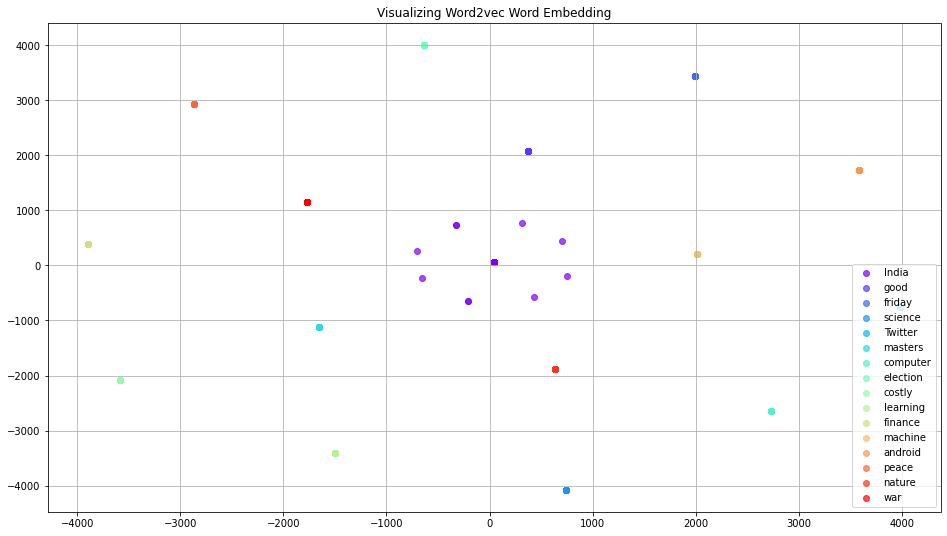

In [46]:
plot_most_similar_words(
    keys, tsne_embeddings, words_clusters, "Visualizing Word2vec Word Embedding"
)

您可以可视化和分析本笔记本中讨论的每个嵌入，还可以向我建议一些新的单词嵌入可视化技术。